In [25]:
from gurobipy import *
#from passenger import *
import pandas as pd

import matplotlib.pyplot as plt
import itertools
import random

# Data and Variables

We need to represent and access info for all passengers: gender (weight), which group they belong to, if they need to transfer quickly, etc. For this purpose we created a the class _Passenger_. We also created the class _Group_ to represent each group (numer of women, men, transit time).

In [26]:
class Passenger(object):
    id_counter = 0
    def __init__(self, group_index, description, class_type, transit_time=0):
        """
            group_index : 
            description : men, women, child, wheelchair, stretcher
            transit_time : optional parameter (inf if there is not transit time)
        """

        self.group_index = group_index
        self.id = Passenger.id_counter
        self.description = description
        self.transit_time = transit_time
        self.class_type = class_type
        self.weight = self.get_weight()

        Passenger.id_counter += 1

    def get_weight(self):
        if self.description == 'women':
            return 70
        elif self.description == 'men':
            return 85
        elif self.description == 'child':
            return 35
        else: 
            return 100 

    def __str__(self):
        return f"{self.id}: ({self.description}, {self.group_index})" 

    def __repr__(self):
        return str(self)

class Group:

    def __init__(self, id, people_count, class_type, transit_time=0):
        self.id = id
        self.class_type = class_type
        self.transit_time = transit_time

        self.members = []

        for desc in people_count:
            for _ in range(people_count[desc]):
                self.members.append(Passenger(
                        self.id,
                        desc,
                        self.class_type,
                        self.transit_time
                    )) 
        
    def __getitem__(self, arg):
        return self.members[arg]

    def __str__(self):
        return f"G{self.id}: " + str(self.members)

    def __repr__(self):
        return str(self)
    

    def __len__(self):
        return len(self.members)
    




We then create some functions to import the data from the spreadsheets.

In [27]:
def read_and_preprocess(file, date):
    df = pd.read_excel(file, date)
    
    df.drop(df.tail(2).index, inplace=True)

    df['TransitTime (min)'] = df['TransitTime'].apply(lambda x: float(str(x).split(':')[0])*60+float(str(x).split(':')[1]))

    df[['Femmes', 'Hommes', 'Enfants', 'WCHR', 'WCHB']] = df[['Femmes', 'Hommes', 'Enfants', 'WCHR', 'WCHB']].fillna(0)

    return df

def get_list_passengers(df):
    list_groups = {}

    for idx, row in df.iterrows():


        people_count = {
            'women': int(row['Femmes']),
            'men': int(row['Hommes']),
            'child': int(row['Enfants']),
            'wheelchair': int(row['WCHR']),
            'stretcher': int(row['WCHB']),
        }

        list_groups[int(idx)] = Group(
            id=int(row["Numéro du groupe"])-1, # -1 temporary fix for ids
            people_count = people_count,
            class_type = row["Classe"],
            transit_time=row['TransitTime (min)']
        )
    
    return list_groups




In [28]:
airplane = dict()

airplane['xmax'] = 28
airplane['ymax'] = 7
airplane['corridor_y'] = 4
airplane['max_transition_row'] = 13
airplane['exit'] = 12

airplane['seats'] = dict()

# considering there is only business class
real_seats = []
corridor_seats = []
transition_seats = []
business = [[1,1], [1,3]]

for x in range(1, airplane['xmax']+1):
    for y  in range(1, airplane['ymax']+1):
        if y != airplane['corridor_y']:
            real_seats.append([x, y])
        if y == airplane['corridor_y']:
            corridor_seats.append([x, y])
        if x <= airplane['max_transition_row'] and y != airplane['corridor_y']:
            transition_seats.append([x, y])

for x in range(2, 10):
    for y in range(1, 8, 2):
        business.append([x, y])

exit_seats = list()
for y in range(1, 8):
    if x!=4:
        exit_seats.append([12, y])

# economic class
econo_class = list()
for x in range(10, airplane['xmax']+1):
    for y in range(1, airplane['ymax']+1):
        if y!= airplane['corridor_y']:
            econo_class.append([x, y])


airplane['seats']['real'] = real_seats
airplane['seats']['corridor'] = corridor_seats
airplane['seats']['transition_possible_seats'] = transition_seats
airplane['seats']['business_class'] = business
airplane['seats']['exit_seats'] = exit_seats
airplane['seats']['econo_class'] = econo_class

del real_seats, corridor_seats, transition_seats, business, exit_seats, econo_class

print(airplane)

{'xmax': 28, 'ymax': 7, 'corridor_y': 4, 'max_transition_row': 13, 'exit': 12, 'seats': {'real': [[1, 1], [1, 2], [1, 3], [1, 5], [1, 6], [1, 7], [2, 1], [2, 2], [2, 3], [2, 5], [2, 6], [2, 7], [3, 1], [3, 2], [3, 3], [3, 5], [3, 6], [3, 7], [4, 1], [4, 2], [4, 3], [4, 5], [4, 6], [4, 7], [5, 1], [5, 2], [5, 3], [5, 5], [5, 6], [5, 7], [6, 1], [6, 2], [6, 3], [6, 5], [6, 6], [6, 7], [7, 1], [7, 2], [7, 3], [7, 5], [7, 6], [7, 7], [8, 1], [8, 2], [8, 3], [8, 5], [8, 6], [8, 7], [9, 1], [9, 2], [9, 3], [9, 5], [9, 6], [9, 7], [10, 1], [10, 2], [10, 3], [10, 5], [10, 6], [10, 7], [11, 1], [11, 2], [11, 3], [11, 5], [11, 6], [11, 7], [12, 1], [12, 2], [12, 3], [12, 5], [12, 6], [12, 7], [13, 1], [13, 2], [13, 3], [13, 5], [13, 6], [13, 7], [14, 1], [14, 2], [14, 3], [14, 5], [14, 6], [14, 7], [15, 1], [15, 2], [15, 3], [15, 5], [15, 6], [15, 7], [16, 1], [16, 2], [16, 3], [16, 5], [16, 6], [16, 7], [17, 1], [17, 2], [17, 3], [17, 5], [17, 6], [17, 7], [18, 1], [18, 2], [18, 3], [18, 5], [1

In [29]:
# Load Passengers in data

df = read_and_preprocess('DataSeating.xlsx', '21Oct')

groups = get_list_passengers(df)

passengers = list()

for g in groups.keys():
    passengers += groups[g].members


passenger_from_id = {}
for p in passengers:
    passenger_from_id[p.id] = p


As a final setup we define some problem parameters.

In [30]:

passengers_count = len(passengers)

width = airplane['ymax']-1
height = airplane['xmax']
X = [-3, -2, -1, 0, 1, 2, 3]
Y = list(range(-14,0)) + list(range(1,14+1))

total_weight = sum(p.weight for p in passengers)


# Model Definition

In [31]:
m = Model("model_v1")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-26


The main decision variable here is the allocation $A^p_{(i~,~j)}$ : binary variable that says for each passenger with id $p$ if he is located at the seat in coordinates $(i~,~j)$.


This is represented in python by the variable allocation[p, i, j].

For instance, if passenger 1 is at the place : (2, 3), then allocation[1,2,3] = 1. Else, it equals 0.

In [32]:
# Allocation Variables
allocation = m.addVars(passengers_count, width+1, height, vtype=GRB.BINARY, name="Allocation")

# Constraints

**At most 1 person per seat:** there can't be more than 1 person in each seat.

$$\sum_{p \in \text{Passengers}} A^p_{(i~,~j)} \leq 1~~\forall (i, j) \in \text{Seats}$$

In [33]:
# Make sure that there is at most one person per seat
C_limited_seat = m.addConstrs((quicksum([allocation[p.id,i,j] for p in passengers]) <= 1 for i in range(width+1) for j in range(height)))

**Every passenger is served:** every passenger should be allocated to precisely one seat.

$$\sum_{(i,j) \in \text{Seats}} A^p_{(i~,~j)} == 1~~\forall p \in \text{Passengers}$$

In [34]:
# Maker sure that everyone is seated and only in one spot
C_serve_all = m.addConstrs((quicksum([allocation[p.id,i,j] for i in range(width+1) for j in range(height) ]) == 1 for p in passengers))

**Empty Corridor**: there should be no passenger allocated to the corridor (i=3).
$$A^p_{(i,j)}==0~~\forall (p,i,j) \in \text{Passengers} \times \text{Seats}$$

In [35]:
# Make sure that the corridor is not considered as a possible seat
C_empty_corridor = m.addConstrs((0 == allocation[p,3,j] for p in range(passengers_count) for j in range(height)))

**Barycenter Constraint:** the center of mass of the passengers must reside within a limited area. For this purpose the barycenter function is divided into its X and Y coordinate and then each constraint is divided into an inferior limit and a superior limit constraint.

$$ \frac{1}{w_t}\sum_{(p,i,j) \in \text{Passengers} \times \text{Seats}} A^p_{(i,j)} \cdot w(p) \cdot X(i) \leq B_{max}^X$$

$$ \frac{1}{w_t}\sum_{(p,i,j) \in \text{Passengers} \times \text{Seats}} A^p_{(i,j)} \cdot w(p) \cdot X(i) \geq B_{min}^X$$

$$ \frac{1}{w_t}\sum_{(p,i,j) \in \text{Passengers} \times \text{Seats}} A^p_{(i,j)} \cdot w(p) \cdot Y(j) \leq B_{max}^Y$$

$$ \frac{1}{w_t}\sum_{(p,i,j) \in \text{Passengers} \times \text{Seats}} A^p_{(i,j)} \cdot w(p) \cdot Y(j) \geq B_{min}^Y$$


Where :
- $w_t$ is the total weight of all passengers.
- $w(p)$ is the weight of passenger with id $p$.
- $X(i)$ is the distance in meters at coordinate i.
- $Y(j)$ is the distance in meters at coordinate j.
- $B_{max}^X$ is the upper bound of the barycenter in the X axis.
- $B_{min}^X$ is the lower bound of the barycenter in the X axis.
- $B_{max}^Y$ is the upper bound of the barycenter in the Y axis.
- $B_{min}^Y$ is the lower bound of the barycenter in the Y axis.


In [36]:
# Center of Mass function
barycenter_X = quicksum([p.weight * allocation[p.id,i,j]*X[i] for p in passengers for i in range(width+1) for j in range(height)])/total_weight
barycenter_Y = quicksum([p.weight * allocation[p.id,i,j]*Y[j] for p in passengers for i in range(width+1) for j in range(height)])/total_weight

# Barycenter limits
bary_lim_X = 1
bary_lim_Y = 2

# Make sure that the center of mass is centralized

C_bary_X_p = m.addConstr(barycenter_X <=  bary_lim_X)
C_bary_X_m = m.addConstr(barycenter_X >= -bary_lim_X)
C_bary_Y_p = m.addConstr(barycenter_Y <=  bary_lim_Y)
C_bary_Y_m = m.addConstr(barycenter_Y >= -bary_lim_Y)

**Transit Time Constraint**: the people with a transit time inferior to 90 minutes should stay in the front.

$$ A^p_{(i,j)} \leq \epsilon(p) ~~ \forall (p,i,j) \in \text{Passengers in transit} \times \text{Columns} \times \text{Upper rows}$$

Where $\epsilon(p)$ is a new auxiliary variable that we want to minimize.

In [37]:
epsilon = m.addVars([p.id for p in passengers if p.transit_time < 90], vtype=GRB.BINARY)
m.addConstrs(allocation[p.id,i,j] <= epsilon[p.id] for i in range(width+1) for j in range(height) for p in passengers if p.transit_time < 90 and j > 13);

# Objective Function

As a precise calculation of the satisfying function leads to a combinatorial explosion, we decided to instead try to reduce the rectangle formed by the distribution of people from the same group, in this way they try to collapse to the same region of the plane.

For this we will need the following additional variables:
- $i^G_{max}$: highest $i$ coordinate between members of group $G$.
- $i^G_{min}$: lowest $i$ coordinate between members of group $G$.
- $j^G_{max}$: highest $j$ coordinate between members of group $G$.
- $j^G_{min}$: lowest $j$ coordinate between members of group $G$.
- $\Delta i^G$: $i^G_{max}-i^G_{min}$
- $\Delta j^G$: $j^G_{max}-j^G_{min}$

The first 4 variables are set by defining inequality constraints based on the coordinates of the members of a group and the 2 last variables are set by defining equality constraints. Thus, our objective function becomes.

$$ \sum_{G \in \text{Groups}} \Delta i^G + \phi \cdot \Delta j^G + \sum_{p \in G} \epsilon(p) $$

Where $\phi$ is a factor for giving priorities to grouping people in the same rows.

In [38]:
#i_p = m.addVars(passengers_count, vtype=GRB.INTEGER, lb=0, ub=width, name="i_p")
#j_p = m.addVars(passengers_count, vtype=GRB.INTEGER, lb=0, ub=height, name="j_p")

i_g_max = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=width, name="i_g_max")
i_g_min = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=width, name="i_g_min")
j_g_max = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=height, name="j_g_max")
j_g_min = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=height, name="j_g_min")

#i_g_delta = m.addVars(len(groups), vtype=GRB.INTEGER, lb=1, ub=width, name="i_g_delta")
#j_g_delta = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=height, name="j_g_delta")

#m.addConstrs((i_p[p] == quicksum([i*allocation[p,i,j] for i in range(width+1) for j in range(height)]) for p in range(passengers_count)))
#m.addConstrs((j_p[p] == quicksum([j*allocation[p,i,j] for i in range(width+1) for j in range(height)]) for p in range(passengers_count)))

for g in range(len(groups)):
    if len(groups[g].members) > 1 :
    
        m.addConstrs(( i_g_max[g] >= quicksum([i*allocation[p.id,i,j] for i in range(width+1) for j in range(height)]) for p in groups[g].members ))
        m.addConstrs(( i_g_min[g] <= quicksum([i*allocation[p.id,i,j] for i in range(width+1) for j in range(height)]) for p in groups[g].members ))

        m.addConstrs(( j_g_max[g] >= quicksum([j*allocation[p.id,i,j] for i in range(width+1) for j in range(height)]) for p in groups[g].members ))
        m.addConstrs(( j_g_min[g] <= quicksum([j*allocation[p.id,i,j] for i in range(width+1) for j in range(height)]) for p in groups[g].members ))
        
        m.addConstr(i_g_max[g] >= i_g_min[g])
        m.addConstr(j_g_max[g] >= j_g_min[g])

        #m.addConstr(i_g_delta[g] == i_g_max[g] - i_g_min[g])
        #m.addConstr(j_g_delta[g] == j_g_max[g] - j_g_min[g])

        m.addConstr((i_g_max[g] - i_g_min[g] + j_g_max[g] - j_g_min[g] >= 1))


def in_grid(i, j):
    return i>=0 and j>=0 and j<height and i <= width

e_allocation = lambda p, i, j: allocation[p,i,j] if in_grid(i,j) else 0


m.setObjective( i_g_max.sum() - i_g_min.sum() + 50*j_g_max.sum() - 50*j_g_min.sum() + epsilon.sum(), GRB.MINIMIZE)


**Observation:** unfortunately our objective function couldn't calculate an optimal solution in due time. Thus for this delivery we only considered the $j$ coordinate which is really far away from being a good solution.

In [39]:
#m.setParam("MIPFocus", 3) 
#m.setParam("Cuts", 2) 
#m.setParam('MIPGap', 0.06)
m.update()
m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 14425 rows, 30332 columns and 248160 nonzeros
Model fingerprint: 0x32a0a4ba
Variable types: 0 continuous, 30332 integer (29888 binary)
Coefficient statistics:
  Matrix range     [3e-03, 3e+01]
  Objective range  [1e+00, 5e+01]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective -88217.00000
Presolve removed 13686 rows and 4650 columns
Presolve time: 1.62s
Presolved: 739 rows, 25682 columns, 143345 nonzeros
Variable types: 4 continuous, 25678 integer (25537 binary)

Root relaxation: objective -1.068090e+05, 1607 iterations, 0.40 seconds (0.16 work units)
Total elapsed time = 5.23s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -106809.00    0  134 -88217.000 -

# Verifying Results
- Green Seats: people travelling alone
- Orange Seats: people travelling in group, the printed number corresponds to the group id.
- Asterisk: people with transit time inferior to 90 minutes.
- Blue Rectangle: limits of the acceptable barycenter.
- Red Circle: actual barycenter.

Center of Mass: (0.03, -0.8)
Passenger ID:0 - Coordinate: (6, 11)
Passenger ID:1 - Coordinate: (0, 9)
Passenger ID:2 - Coordinate: (5, 22)
Passenger ID:3 - Coordinate: (2, 11)
Passenger ID:4 - Coordinate: (1, 24)
Passenger ID:5 - Coordinate: (0, 24)
Passenger ID:6 - Coordinate: (5, 2)
Passenger ID:7 - Coordinate: (0, 21)
Passenger ID:8 - Coordinate: (6, 4)
Passenger ID:9 - Coordinate: (5, 4)
Passenger ID:10 - Coordinate: (6, 16)
Passenger ID:11 - Coordinate: (1, 20)
Passenger ID:12 - Coordinate: (0, 16)
Passenger ID:13 - Coordinate: (1, 16)
Passenger ID:14 - Coordinate: (2, 23)
Passenger ID:15 - Coordinate: (0, 18)
Passenger ID:16 - Coordinate: (5, 10)
Passenger ID:17 - Coordinate: (4, 10)
Passenger ID:18 - Coordinate: (4, 19)
Passenger ID:19 - Coordinate: (6, 19)
Passenger ID:20 - Coordinate: (5, 12)
Passenger ID:21 - Coordinate: (4, 12)
Passenger ID:22 - Coordinate: (1, 23)
Passenger ID:23 - Coordinate: (0, 11)
Passenger ID:24 - Coordinate: (4, 11)
Passenger ID:25 - Coordinate: (5, 1

(-3.5, 3.5)

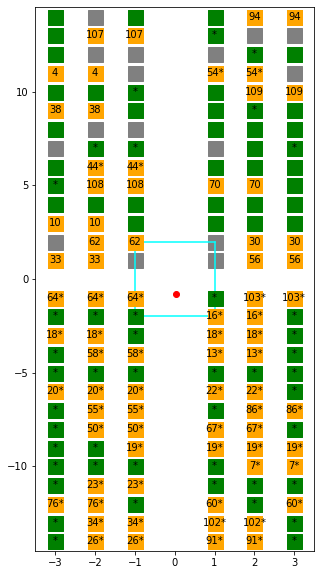

In [40]:
cm_x = round(barycenter_X.getValue(),2)
cm_y = round(barycenter_Y.getValue(),2)

print(f"Center of Mass: {(cm_x, cm_y)}")


fig = plt.figure(figsize=(5,10));
for seat in itertools.product(X,Y):
    if seat[0] != 0:
        plt.plot(seat[0],seat[1],'s', color="gray", markersize=15)

plt.plot([bary_lim_X, bary_lim_X]  , [-bary_lim_Y, bary_lim_Y],   color="cyan")
plt.plot([-bary_lim_X, -bary_lim_X], [-bary_lim_Y, bary_lim_Y],   color="cyan")
plt.plot([-bary_lim_X, bary_lim_X] , [bary_lim_Y, bary_lim_Y],    color="cyan")
plt.plot([-bary_lim_X, bary_lim_X] , [-bary_lim_Y, -bary_lim_Y],   color="cyan")

#for g in range(len(groups)):
    #print(j_g_max[g].x, j_g_min[g].x)

for a in allocation:
    if allocation[a].x == 1:
        label = ""
        if len(groups[passenger_from_id[a[0]].group_index].members) == 1:
            color = "green"
        else:
            color = "orange"
            label = label + str(passengers[a[0]].group_index)
            

        
        #plt.plot(X[a[1]],Y[a[2]], 'o',color=colors[passengers[a[0]].group_index-1])
        plt.plot(X[a[1]], Y[a[2]], 's', color=color, markersize=15)
        plt.text(X[a[1]], Y[a[2]],label+"*"*(passenger_from_id[a[0]].transit_time < 90), ha="center", va="center")
        print(f"Passenger ID:{a[0]} - Coordinate: {(a[1], a[2])}")
plt.plot(cm_x,cm_y, "o", color="red")
plt.ylim([-14.5,14.5])
plt.xlim([-3.5,3.5])